<a href="https://colab.research.google.com/github/LilKedin/Inflation_Model/blob/main/Inflation_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# These are the basic import statements to get the required Python functionality
%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.offline as py
import plotly.graph_objects as go
#import chart_studio.plotly as py2
#import cufflinks as cf

#from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
#init_notebook_mode(connected=True)
#cf.go_offline()


from fbprophet import Prophet
#import plotly.plotly as py
import plotly.graph_objs as go
import datetime
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from datetime import date

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data

For this example, I consider modeling quarterly CPI inflation. Below, I retrieve the data directly from the [Federal Reserve Economic Database](https://fred.stlouisfed.org/) using the `pandas_datareader` package.

In [2]:
# Get the data from FRED
from pandas_datareader.data import DataReader
cpi = DataReader('CPIAUCNS', 'fred', start='1971-01', end='2022-12')
cpi.index = pd.DatetimeIndex(cpi.index, freq='MS')
inf = np.log(cpi).resample('QS').mean().diff()[1:] * 400
df = pd.DataFrame(inf)

traces = [go.Scatter(x=df.index,
                     y=df[col],
                     name=col)
          for col in df.columns]
py.iplot(traces)

## State space model

Below I construct a custom class, `ARMA11`, to estimate the ARMA(1, 1) model.

In [3]:
from statsmodels.tsa.statespace.tools import (constrain_stationary_univariate,
                                              unconstrain_stationary_univariate)

class ARMA11(sm.tsa.statespace.MLEModel):
    start_params = [0, 0, 1]
    param_names = ['phi', 'theta', 'sigma2']

    def __init__(self, endog):
        super(ARMA11, self).__init__(
            endog, k_states=2, k_posdef=1, initialization='stationary')

        self['design', 0, 0] = 1.
        self['transition', 1, 0] = 1.
        self['selection', 0, 0] = 1.

    def transform_params(self, params):
        phi = constrain_stationary_univariate(params[0:1])
        theta = constrain_stationary_univariate(params[1:2])
        sigma2 = params[2]**2
        return np.r_[phi, theta, sigma2]

    def untransform_params(self, params):
        phi = unconstrain_stationary_univariate(params[0:1])
        theta = unconstrain_stationary_univariate(params[1:2])
        sigma2 = params[2]**0.5
        return np.r_[phi, theta, sigma2]

    def update(self, params, **kwargs):
        # Transform the parameters if they are not yet transformed
        params = super(ARMA11, self).update(params, **kwargs)

        self['design', 0, 1] = params[1]
        self['transition', 0, 0] = params[0]
        self['state_cov', 0, 0] = params[2]

## Maximum likelihood estimation

With this class, I can instantiate a new object with the inflation data and fit the model by maximum likelihood methods.

In [4]:
inf_model = ARMA11(inf)
inf_results = inf_model.fit()

print(inf_results.summary())

                           Statespace Model Results                           
Dep. Variable:               CPIAUCNS   No. Observations:                  205
Model:                         ARMA11   Log Likelihood                -483.892
Date:                Sun, 15 May 2022   AIC                            973.784
Time:                        16:23:17   BIC                            983.753
Sample:                    04-01-1971   HQIC                           977.816
                         - 04-01-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
phi            0.9801      0.016     62.237      0.000       0.949       1.011
theta         -0.6174      0.058    -10.555      0.000      -0.732      -0.503
sigma2         6.5140      0.328     19.868      0.0

I can produce in-sample one-step-ahead predictions and out-of-sample forecasts:

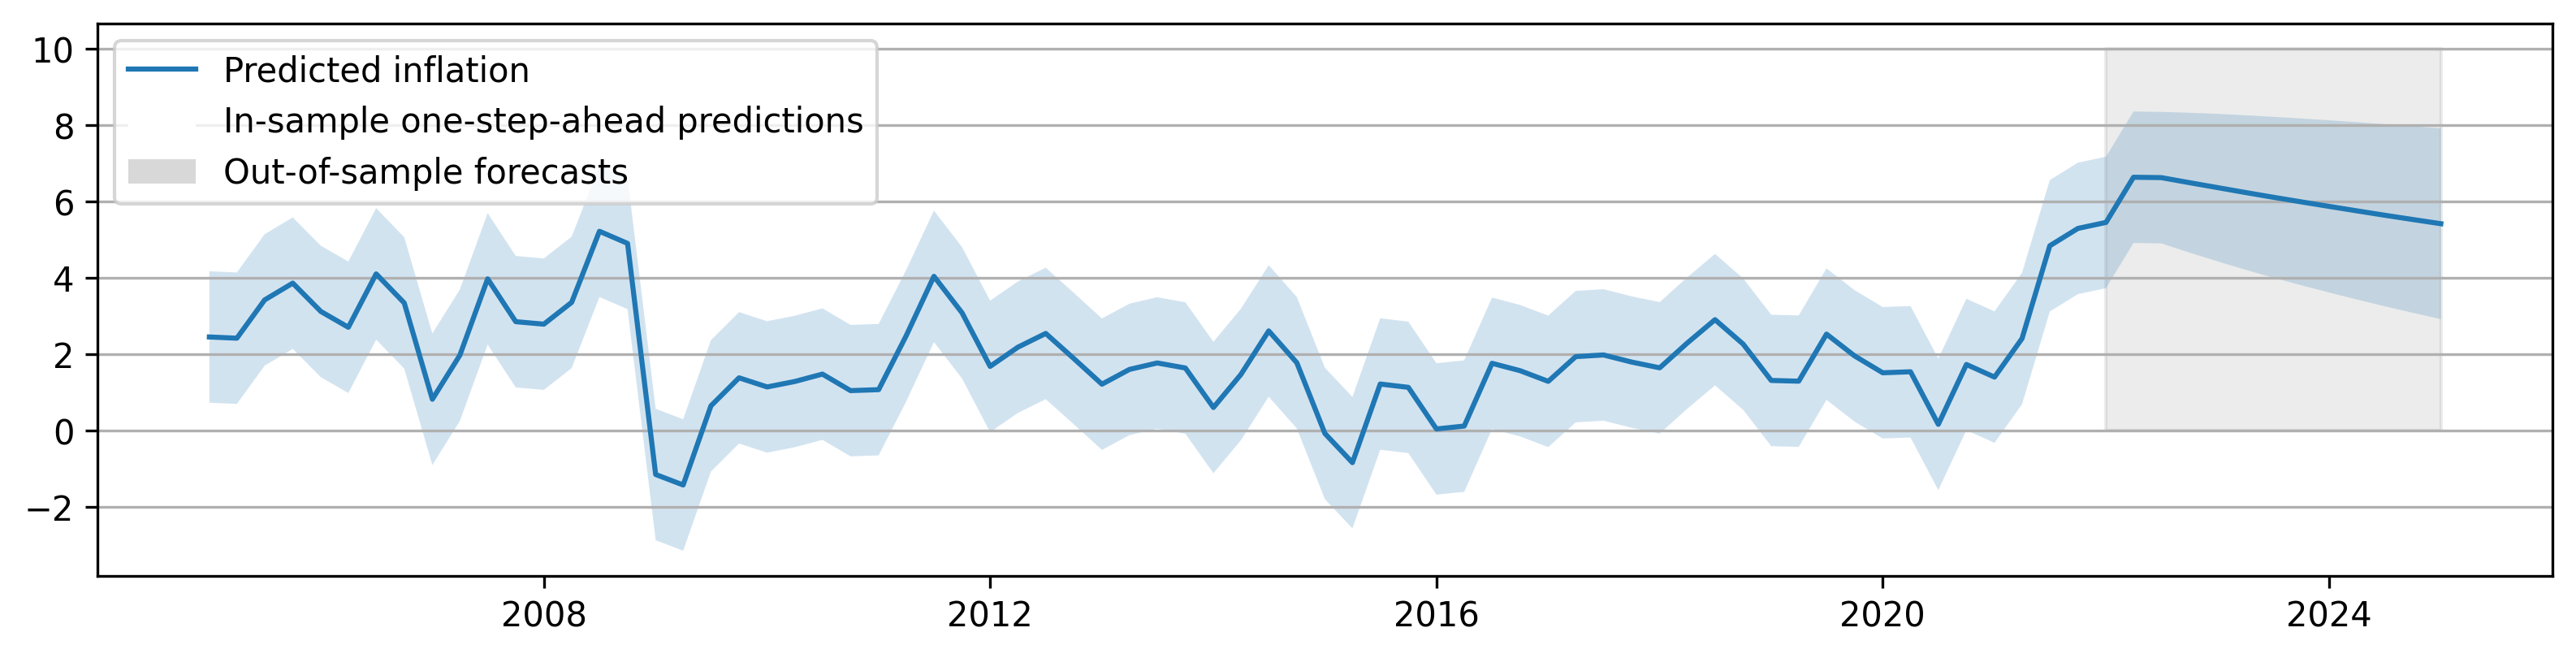

In [9]:
# Construct the predictions / forecasts
inf_forecast = inf_results.get_prediction(start='2005-01-01', end='2025-01-01')

# Plot them
fig, ax = plt.subplots(figsize=(13, 3), dpi=300)

forecast = inf_forecast.predicted_mean
ci = inf_forecast.conf_int(alpha=0.5)

ax.fill_between(forecast['2022-01-01':].index, 0, 10, color='grey',
                alpha=0.15)
lines, = ax.plot(forecast.index, forecast)
ax.fill_between(forecast.index, ci['lower CPIAUCNS'], ci['upper CPIAUCNS'],
                alpha=0.2)

p1 = plt.Rectangle((0, 0), 1, 1, fc="white")
p2 = plt.Rectangle((0, 0), 1, 1, fc="grey", alpha=0.3)
ax.legend([lines, p1, p2], ["Predicted inflation",
                            "In-sample one-step-ahead predictions",
                            "Out-of-sample forecasts"], loc='upper left')
ax.yaxis.grid()

I made the graph below interactive so it is better for the user experience.

In [10]:
# Collecting data in an Array
data = [forecast.index, ci['lower CPIAUCNS'], ci['upper CPIAUCNS']]

# Creating the layout of the Chart
layout = go.Layout(
  yaxis = {
    'title': 'Predicted inflation'
  },
  hovermode = 'x',
  xaxis = {
    'title': 'Date'
  },
  margin = {
    't': 20,
    'b': 50,
    'l': 60,
    'r': 10
  },
  legend = {
    'bgcolor': 'rgba(0,0,0,0)'
  }
)


px.line(df, x = forecast.index, y = [forecast, ci['lower CPIAUCNS'], ci['upper CPIAUCNS']],
        labels={'x' : 'Date', 'y' : 'Value'}, title = 'Inflation Forecast')

# Personalizing the Chart
fig = go.Figure()
fig.add_trace(go.Scatter(x=forecast.index,y=forecast,mode='lines',name='Forecast'))
fig.add_trace(go.Scatter(x=forecast.index,y=ci['lower CPIAUCNS'],mode='lines+markers',name='Low Forecast',line=dict(color='green',width=2,dash='dot')))
fig.add_trace(go.Scatter(x=forecast.index,y=ci['upper CPIAUCNS'],mode='lines+markers',name='High Forecast',line=dict(color='firebrick',width=2,dash='dot')))

fig.update_layout(title='Inflation Forecast', xaxis_title = 'Date', yaxis_title = 'Inflation % YoY' )



##Conclusion

I realized a simple code using the already Python-implented prediction() function. I made the charts interactive with Plotly so it is easier to zoom-in and see each point clearly.

Many parameters could be added to make the model better. I could take into account PCE, PMI, Fed Rates to make the model more accurate (smaller High-Low forecast difference).

With enough time, there are many parameters that are possible to include as well such as WPI, PPI, freight price index, energy prices, real vs. nominal GDP & IP differences, CRB to cover commodities, inventories of various sorts. 

I could also work on comparing leading vs. lagging indicators to understand better the global situation.